In [1]:
import sys
import json
import os
import glob
import time
%tensorflow_version 2.x
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import imageio
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical   
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/scripts')

import dcgan, cgan
import inception_score, inception_model

#from inception_score import *
#from inception_model import *
from importlib import reload
dcgan = reload(dcgan)
cgan = reload(cgan)
inception_model = reload(inception_model)
inception_score = reload(inception_score)

tf.__version__

TensorFlow 2.x selected.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


'2.1.0'

# **Loading and shuffling training data**

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# #normalise data between -1 and 1 (given min is 0 and max is 255)
# x_train_n = 2 * ( x_train - 0 ) / (255 - 0) - 1
# x_test_n = 2 * ( x_test - 0 ) / (255 - 0) - 1

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Create one hot encoding
labels = to_categorical(y_train, num_classes=10)

# Random seed and get shuffled indices
# tf.random.set_seed(80085)
indices = tf.range(start=0, limit=BUFFER_SIZE, dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train,shuffled_indices)
labels = tf.gather(labels,shuffled_indices)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE,drop_remainder=True)
train_labels = tf.data.Dataset.from_tensor_slices(labels).batch(BATCH_SIZE,drop_remainder=True)

# **Creating and training a model**

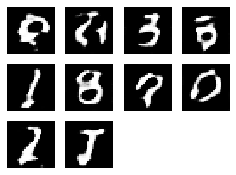

Time for epoch 12 is 28.73882246017456 sec
Generator loss: 0.6079279184341431
Discriminator loss: 0.5428396463394165


In [0]:
model = dcgan.dcgan(batch_size=BATCH_SIZE, filters=1)
G_loss, D_loss = model.train(train_dataset, train_labels, epochs=25)

Saving model


In [0]:
name = "dgan_e50_d1_f1_b64"
tf.saved_model.save(model.G, "/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
tf.saved_model.save(model.D, "/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", G_loss, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", D_loss, delimiter=',')

# **Testing**

DCGAN testing

In [0]:
name = "dcgan_e50_d1_f2_b128"
loaded = dcgan.dcgan(20,20,BATCH_SIZE)
loaded.G = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
loaded.D = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
loaded_G_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
loaded_D_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')

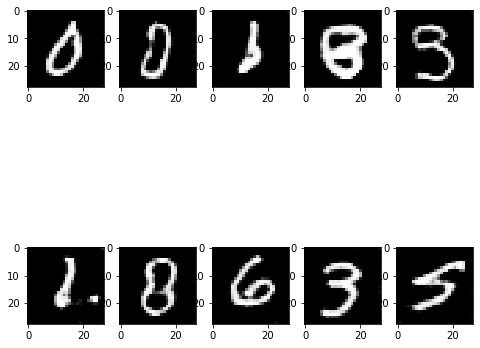

In [0]:
fig = plt.figure(figsize=(8, 8))
for i in range(1,11): 
  noise = tf.random.normal([1,100])
  image = loaded.G(noise,training=False)
  fig.add_subplot(2, 5, i)
  plt.imshow(image[0,:,:,0],cmap='gray')

CGAN testing

In [0]:
name = "cgan_d1_f2_b128"
loaded = cgan.cgan(20,20)
loaded.G = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
loaded.D = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
loaded_G_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
loaded_D_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')

In [0]:
tf.random.set_seed(np.random.randint(1000))
noise = tf.random.normal([1,100])
#np.random.seed(1)
label = to_categorical([9],num_classes=10)

image = model.G([noise,label],training=False)
plt.imshow(image[0,:,:,0],cmap='gray')
print(label)

AttributeError: ignored

# **Loss graphs**

Text(0.5, 1.0, 'Discriminator loss')

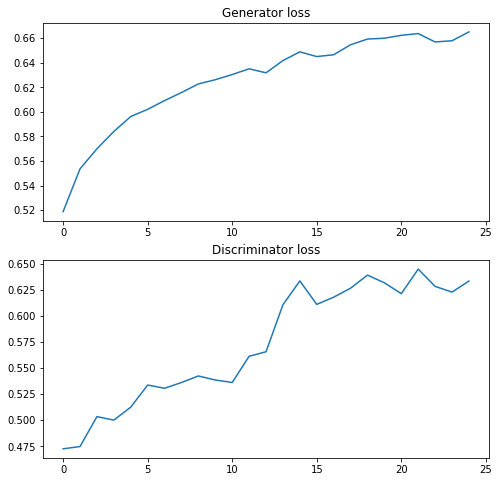

In [0]:
loss_fig = plt.figure(figsize=(8, 8))

loss_fig.add_subplot(2, 1, 1)
plt.plot(loaded_G_loss)
plt.title("Generator loss")

loss_fig.add_subplot(2, 1, 2)
plt.plot(loaded_D_loss)
plt.title("Discriminator loss")

Loading all the model losses

In [0]:
g_losses = {}
d_losses = {}
for d in range(1,3):
  for f in range(1,3):
    name = 'dcgan_e50_d{}_f{}'.format(d,f)
    g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
    d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
    

Plotting all the model losses

In [0]:
loss_fig = plt.figure(figsize=(8, 8))

loss_fig.add_subplot(2, 1, 1)
plt.plot(g_losses)
plt.title("Generator losses")

loss_fig.add_subplot(2, 1, 2)
plt.plot(d_losses)
plt.title("Discriminator losses")

# **Inception Score**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

x_test = (x_test - 127.5) / 127.5 # Normalize the images to [-1, 1]
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

model = tf.keras.Sequential()
model.add(layers.Conv2D(28, kernel_size=(3,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10,activation=tf.nn.softmax))

#model.summary()            

In [5]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=15)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 6s 99us/sample - loss: 1.4833 - accuracy: 0.9811
Epoch 2/15
60000/60000 [==============================] - 6s 93us/sample - loss: 1.4815 - accuracy: 0.9827
Epoch 3/15
60000/60000 [==============================] - 5s 91us/sample - loss: 1.4800 - accuracy: 0.9841
Epoch 4/15
60000/60000 [==============================] - 5s 88us/sample - loss: 1.4786 - accuracy: 0.9853
Epoch 5/15
60000/60000 [==============================] - 5s 89us/sample - loss: 1.4780 - accuracy: 0.9856
Epoch 6/15
60000/60000 [==============================] - 5s 89us/sample - loss: 1.4769 - accuracy: 0.9869
Epoch 7/15
60000/60000 [==============================] - 5s 87us/sample - loss: 1.4758 - accuracy: 0.9876
Epoch 8/15
60000/60000 [==============================] - 5s 87us/sample - loss: 1.4751 - accuracy: 0.9887
Epoch 9/15
60000/60000 [==============================] - 5s 86us/sample - loss: 1.4741 - accuracy: 0.9893
Epoch 10/15
60

In [25]:
total = 1000
noise = tf.random.normal([total,100])
lol = np.random.randint(10, size=total)
label = to_categorical(lol,num_classes=10)

images = loaded.G([noise,label],training=False)
predictions = model.predict(images)
num_correct = 0
for i in range(total):
  if np.argmax(predictions[i]) == lol[i]:
    num_correct = num_correct + 1

print(num_correct/total)

0.963


In [26]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 69us/sample - loss: 1.4756 - accuracy: 0.9864


[1.4755936491012573, 0.9864]